## Classification of Income Being Above or Below/Equal to $50,000 in Adult Census Data

By: Sunsar, Sarah, Emily, Calvin (DSCI 100 003 - Group 23)

Data is from: https://www.kaggle.com/datasets/uciml/adult-census-income

The dataset used for this analysis is derived from the 1994 Census Bureau database. 

The dataset contains a diverse range of numerical and categorical attributes, such as age, hours worked per week,  sex, and more. In this project, we will filter and simplify some categories from this dataset to predict whether an individual"s annual salary falls above or below/equal to $50,000.

The question this project will seek to answer is: 

**How do different aspects of a person predict whether annual income will be above or below/equal to $50K annually?**

# Reading in Data

In [1]:
library(tidyverse)
library(tidymodels)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.3     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
-- Attaching packages -------------------------------------- tidymodels 1.1.1 --

v broom        1.0.5     v rsample      1.2.0
v dials        1.2.0     v tune         1.1.2
v infer        1.0.5     v workflows    1.1.3
v modeldata    1.2.0     v workflowsets 1.0.1
v parsnip      1.1.1     v yardstick    1.2.0
v recipes      1.0.8     

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x scales::discard() masks purrr::discard()
x dplyr::filt

In [2]:
set.seed(123)

df = read_csv("https://raw.githubusercontent.com/calvingdu/dsci100-003-23/master/data/adult_census.csv")

# Splitting the data
df_split <- initial_split(df, prop = 0.8, strata = income)
df_train <- training(df_split)
df_test <- testing(df_split)

paste0("Training set row count: ", nrow(df_train))
paste0("Testing set row count: ", nrow(df_test))

Rows: 32561 Columns: 15
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Training set row count: 26048"

[1] "Testing set row count: 6513"

In [3]:
head(df_train, 3)

age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K


# Tidying/Cleaning The Data & Selecting Columns
We can begin by tidying up the data. Something we noticed immediately that there are a lot of categorical columns. To tackle this, we plan to make buckets of categories and then turn them into dummy variables. For example, we can turn __sex__ into a dummy variable where 0 = male and 1 = female, make dummy variables by bucketting different things such as paid/unpaid in __workclass__, or making a dummy variable for every unique value. 

These are the columns we plan to use and how we plan to tackle them to make them usable in data: 
- **Age**: No changes (either than scaling/imputation)
- **Education**: Simplified to a dummy variable of if College Graduate or Not
- **Occupation**: Make a dummy variable for all the occupations
- **Sex**: Transformed into a Dummy Variable
- **Capital Gain**: No changes (either than scaling/imputation)
- **Capital Loss**: No changes (either than scaling/imputation)
- **Hours Per Week**: No changes (either than scaling/imputation)
- **Native Country**: Turned into dummy variable of domestic (for the United States) since this data comes from the U.S Census Bureau

**Dropped Columns & Reasoning**: 
- fnlwgt: Unclear how this relates
- education.num: Already have education
- Workclass: Don"t believe this is significant to the study so removing to avoid overfitting 
- race: Don"t believe this is significant to the study so removing to avoid overfitting 
- marital.status: Don"t believe this is significant to the study so removing to avoid overfitting
- Relationship: Don"t believe this is significant to the study so removing to avoid overfitting


This is also some tidying to do. We can initially see that there are some missing values in __workclass__ and __occupation__ represented as ?. Since we believe these are extremely important roles to guess income category, we remove any rows that don't have data for this. 

In [4]:
filtered_df <- df_train |>
  select(age, education, occupation, sex,
         capital.gain, capital.loss, hours.per.week, native.country, income) |>
  filter(occupation != "?")

Then, we can begin by making dummy variables in the data using the above choices

### Binary Preprocessing

In [5]:
# Making a function to be used later
preprocess_binary <- function(df){
    transformed_df <- df |>
        mutate(college_grad = ifelse(education == 'Some-college'| education =='Masters'| education =='Bachelors' | education == "Prof-school",1,0)) |>
        mutate(sex_dummy = ifelse(sex == "Female", 1, 0)) |>
        mutate(domestic = ifelse(native.country == "United-States", 1, 0))
    return(transformed_df)
}

binary_df <- preprocess_binary(filtered_df)

### Dummy Variables for Every Occupation

In [6]:
unique_occupations <- as.list(unique(binary_df$occupation))

# Making a function to use later
preprocess_occupation <- function(df, occupations){
    for (occ in occupations) {
        col_name <- gsub("[^a-zA-Z0-9 ]", ".", tolower(occ))
        df[[col_name]] <- as.integer(df$occupation == occ)
    }
    return(df)
}

tidy_df <- preprocess_occupation(binary_df, unique_occupations)

Below is an function that does all of our pre-processing. It can be verified by checking if the changes we made above are the same as the changes made by the function

In [7]:
process_df <- function(df){
    filtered_df <- df |>
        select(age, education, occupation, sex,
                capital.gain, capital.loss, hours.per.week, native.country, income) |>
        filter(occupation != "?")

    binary_df <- preprocess_binary(filtered_df)

    unique_occupations <- as.list(unique(binary_df$occupation))
    occupations_df <- preprocess_occupation(binary_df, unique_occupations) 

    return(occupations_df)
}

processed_df_train <- process_df(df_train)
print(all.equal(processed_df_train, tidy_df) & all.equal(colnames(processed_df_train), colnames(tidy_df)))

[1] TRUE


# Exploratory Data Analysis



## Summary Table

In [8]:
summary_table <- tidy_df |>
select(-c(education, occupation, native.country)) |>
group_by(income) |>
summarize(across(everything(), ~ round(mean(., na.rm = TRUE), 2), .names = "mean_{.col}")) 

summary_table

Warning message:
"There were 2 warnings in `summarize()`.
The first warning was:
i In argument: `across(everything(), ~round(mean(., na.rm = TRUE), 2), .names =
  "mean_{.col}")`.
i In group 1: `income = "<=50K"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
i Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."


income,mean_age,mean_sex,mean_capital.gain,mean_capital.loss,mean_hours.per.week,mean_college_grad,mean_sex_dummy,mean_domestic,mean_exec.managerial,...,mean_sales,mean_transport.moving,mean_craft.repair,mean_other.service,mean_farming.fishing,mean_protective.serv,mean_tech.support,mean_handlers.cleaners,mean_priv.house.serv,mean_armed.forces
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<=50K,36.54,NA,143.81,53.95,39.39,0.40,0.38,0.89,0.09,...,0.12,0.05,0.14,0.13,0.04,0.02,0.03,0.06,0.01,0
>50K,43.92,NA,4094.82,196.29,45.76,0.64,0.15,0.92,0.26,...,0.13,0.04,0.12,0.02,0.01,0.03,0.04,0.01,0.00,0


This table shows the mean value for every column in each category split by the income category

## How Domestic Status and Education Effect Income

"In 1997, the wage premium was 63 percent for a university degree, and it was 20 percent for other types of higher education." (Park et al., 2020)

This quote states that graduates with a university degree will have a 63% wage premium than those without. This essentially states that those with a degree have higher earning potential than those without. 

`summarise()` has grouped output by 'domestic'. You can override using the
`.groups` argument.


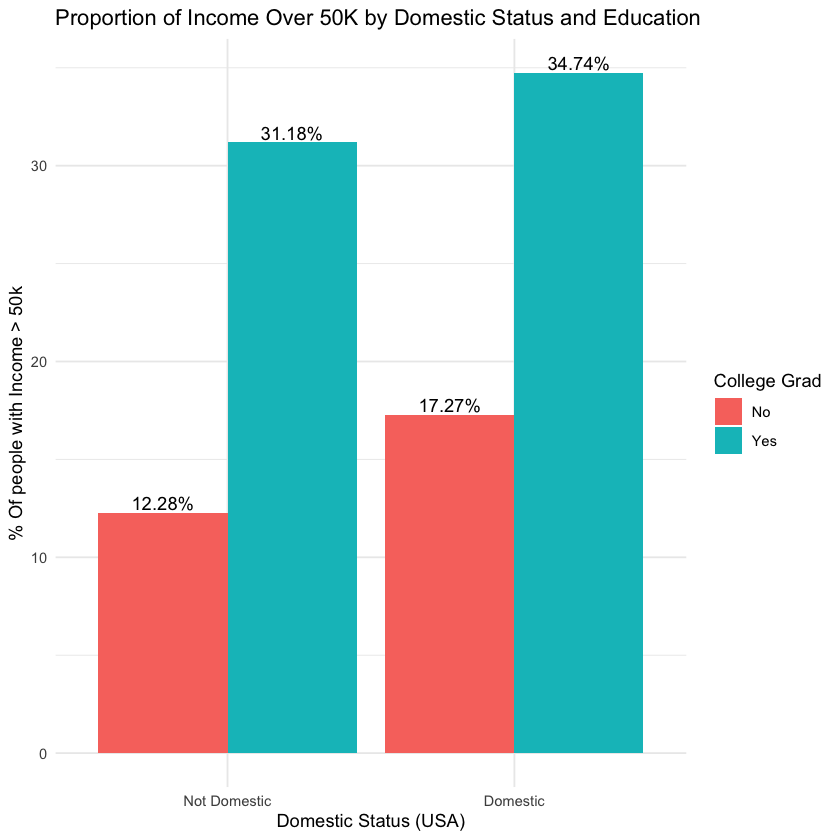

In [15]:
data <- tidy_df %>%
  group_by(domestic, college_grad) %>%
  summarize(proportion = (sum(income == ">50K") / n()) * 100) %>%
  ungroup() %>%
  mutate(domestic = factor(domestic, labels = c("Not Domestic", "Domestic")),
         college_grad = factor(college_grad, labels = c("No", "Yes")))

ggplot(data, aes(x = domestic, y = proportion, fill = college_grad)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  labs(y = "% Of people with Income > 50k", x = "Domestic Status (USA)", title = "Proportion of Income Over 50K by Domestic Status and Education", fill = "College Grad") +
  theme_minimal() +
  geom_text(aes(label = sprintf("%.2f%%", proportion)), 
            position = position_dodge(width = 0.9), 
            vjust = -0.25)

## How Occupation Effects Income

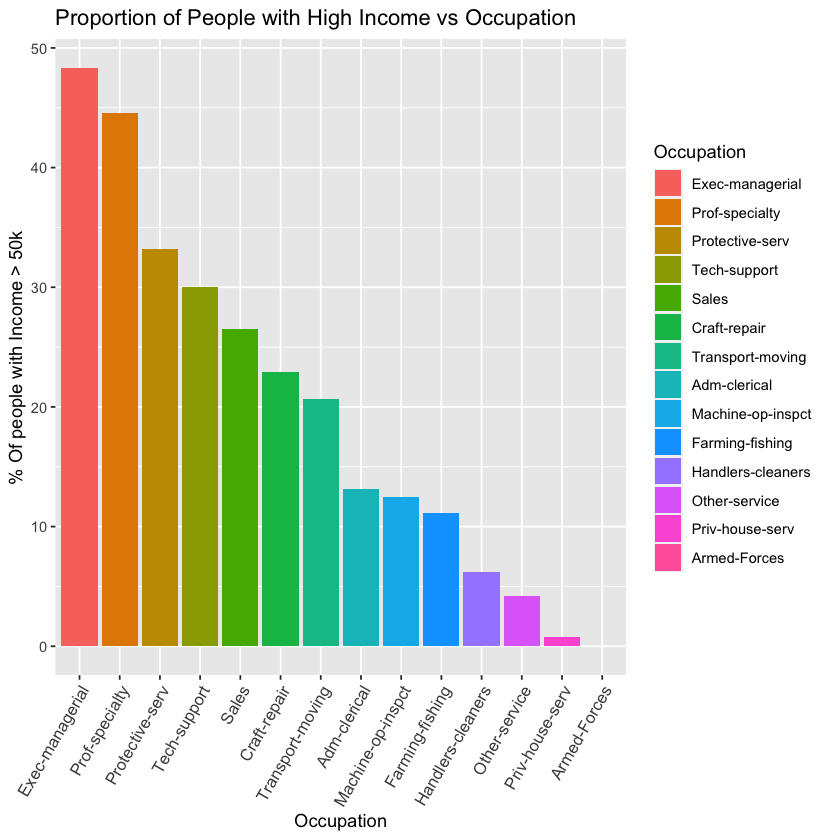

In [11]:
tidy_df %>% 
group_by(occupation) %>% 
summarize(proportion = (sum(income == ">50K") / n()) * 100) %>% 
ggplot(aes(x = reorder(occupation, -proportion), y = proportion, fill = reorder(occupation, -proportion))) + 
geom_bar(stat = "identity") + 
labs(x = "Occupation", y = "% Of people with Income > 50k", title = "Proportion of People with High Income vs Occupation", fill = "Occupation") + 
theme(axis.text.x = element_text(size = 10, angle = 60, hjust = 1)) 

The main aim of this graph is to analyze the relationship between people’s income and their occupation. The data is visualized using a bar plot with each occupation in a different color for effective visualization. The x axis represents the occupation of the people while the y axis represents the percentage of people whose annual income is >=50k in a specific occupation. There were 14 different types of occupations in the dataset with the executive managers forming the greatest percentage of people in the list and the private house servers having the least percentage of people with a high income. 

We can see that what we expect to be high-paying jobs (white-collar jobs) have the highest proportion of people with income > 50k and this decreases as we get into manual labour work. This showcases that the type of job will have a large impact on whether or not people can meet this income threshold.

## How Sex Effects High Income
*"There are sizeable earnings differentials by both gender and race in the U.S. labor market, with women earning less than men"* (Greenman & Xie, 2008)

This article claims that there's a pattern between sex in income class. We can explore our dataset to see how the patterns here compares to this claim

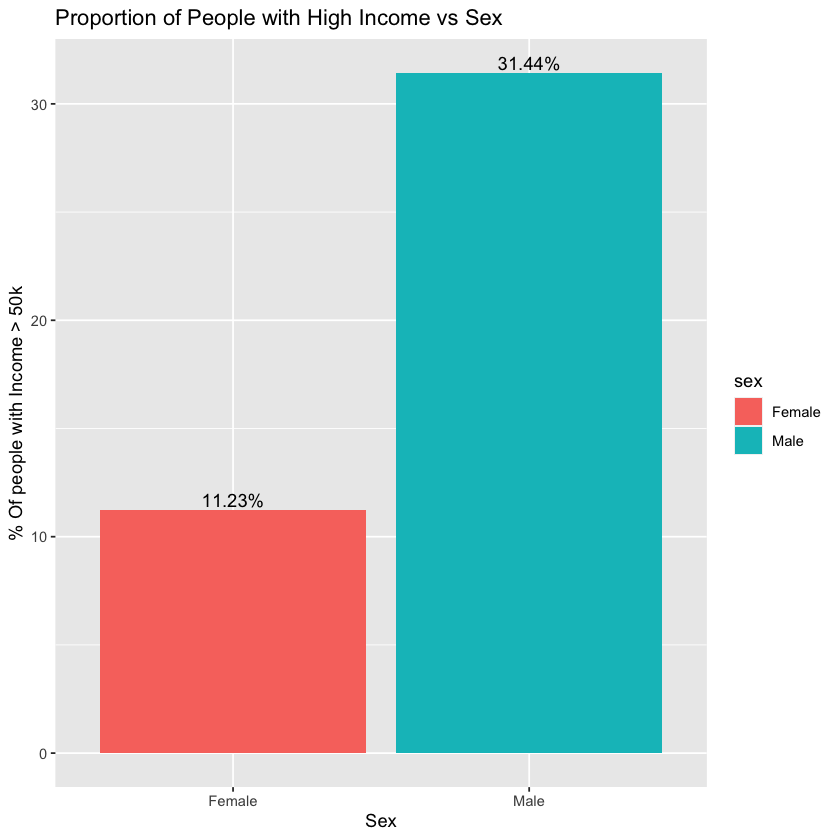

In [12]:
sex_plot <- tidy_df %>% 
    group_by(sex) %>% 
    summarize(proportion = (sum(income == ">50K") / n()) * 100) %>% 
    ggplot(aes(x = sex, y = proportion, fill = sex)) + 
    geom_bar(stat = "identity") + 
    labs(x = "Sex", y = "% Of people with Income > 50k", title = "Proportion of People with High Income vs Sex") + 
    geom_text(aes(label = sprintf("%.2f%%", proportion)), 
        position = position_dodge(width = 0.9), 
        vjust = -0.25)
sex_plot


Greenman and Xie discuss gender-based wage gaps, consistently finding that men earn more than women (2018). Their work is supported by other previous papers, where this pattern of gender differences results in earning inequalities. 
Our dataset is based on yearly income being greater than or less than/equal to $50,000 per year. One of the attributes in this dataset is sex, differentiated into male or female. We visualized this data in a bar graph, separating the two Sex categories, male and female on the x-axis. The y-axis is the Percentage of individuals with income greater than $50,000 annually. The graph supports the claims made by the Greenman and Xie paper, as our data shows that a higher percentage of males (about 31%) earn more than $50,000 per year compared to about 11% of females achieving that mark. 


## How Age Effects High Income

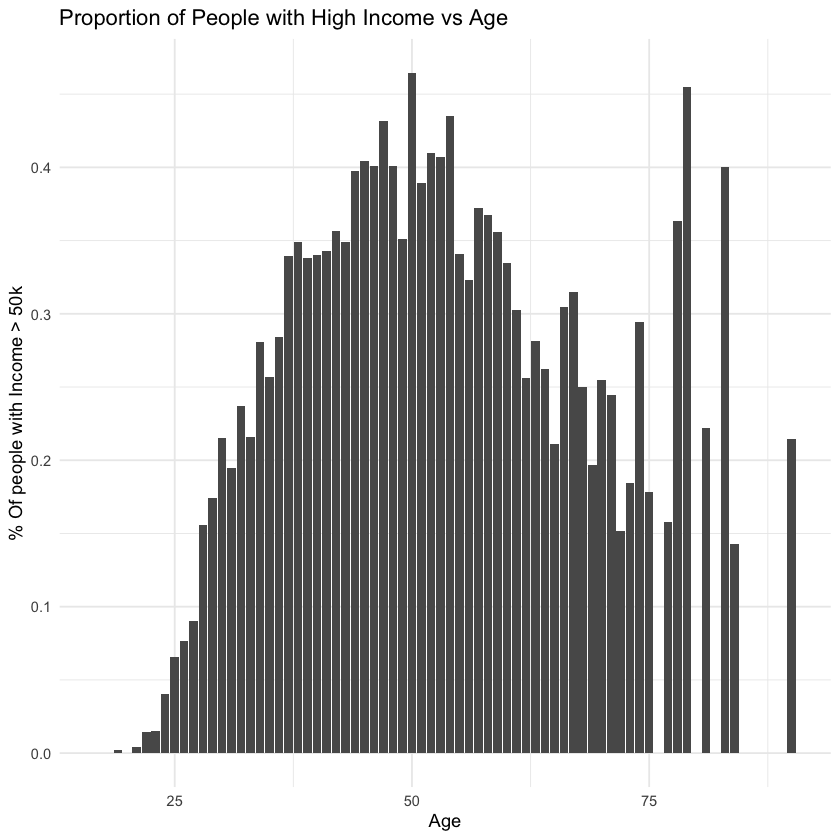

In [13]:
age_plot <- tidy_df %>%
  group_by(age) %>%
  summarise(proportion = sum(income == ">50K") / n()) |>
    ggplot(aes(x = age, y = proportion)) +
    geom_bar(stat = "identity") +
    labs(x = "Age", y = "% Of people with Income > 50k") +
    ggtitle("Proportion of People with High Income vs Age") + 
    theme_minimal()
  
  age_plot

Aiming to figure out the relationship between the age and people’s income which is higher than 50K. We visualize the data with a bar plot and this is some of our observations: 
1. Between 20 to 75, it closes to the unimodal which peaks at about 50. After 75, we start seeing outliers and perhaps another peek.
2. The peak is around 50, implying that at this age more people have an income > 50k because this is where the highest proportion of people with that income is.
3. The range of the plot is from 20 to 80. However, the plot probably have some outliers after 75 that we can explore

In [14]:
tidy_df %>% 
filter(age > 75) %>%  
select(age, occupation) %>% 
group_by(occupation) %>% 
summarize (count_occ = n()) %>% 
arrange(-count_occ)

occupation,count_occ
<chr>,<int>
Exec-managerial,25
Prof-specialty,17
Sales,17
Adm-clerical,16
Other-service,15
Craft-repair,11
Farming-fishing,11
Machine-op-inspct,5
Priv-house-serv,5


At the age 75, the bar plot has an inflection point which the shape changes from decreasing to increasing. Trying to investigate what aspects influence the data after 75. We decide to focus on the occupations to see if we can provide some more information. Using the info above, we can see the counts of each occupation that have the income over 50K higher than age 75. This is what we observe: 

We can see that typically, people older than 75 are executive managers, profs in sales and other high-paying jobs. This can explain why the proportion at this age is generally high because these people have become at the top of their fields, and earning high salaries.

Conclusion: The increasing shape of plot after age 75 can be explained by occupations people older than 75 have which are roles like executive managers. This is why our plot looks like this. Either than these points, the plot first increases, then after about 50, it decreases. Hence, people whose age less than 50 get higher income when their ages increase and decrease after getting older unless they stay in more tenured positions such as executive managers/professors. 

---

## References Cited (APA)
- Park, Y., Kyui, N., &amp; Galassi, G. (2020, October 7). Learning and earning. Bank of Canada. https://www.bankofcanada.ca/2020/10/learning-and-earning/#:~:text=How%20much%20more%20you%20earn,skills%20you%20learned%20in%20school 
- Greenman, E., & Xie, Y. (2008). Double Jeopardy? The Interaction of Gender and Race on Earnings in the U.S. Social forces; a scientific medium of social study and interpretation, 86(3), 1217–1244. https://doi.org/10.1353/sof.0.0008